## Прогноз выручки крупной ритейл компании TGX (USA)

Импртируем необходимые библиотеки и выгрузим данные:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from statsmodels.formula.api import ols

In [2]:
Orders = pd.read_excel('data.xlsx', sheet_name = 'Orders' )
Products = pd.read_excel('data.xlsx', sheet_name = 'Products' )
Address = pd.read_excel('data.xlsx', sheet_name = 'Order address' )
Customers = pd.read_excel('data.xlsx', sheet_name = 'Customers' )
Returns = pd.read_excel('data.xlsx', sheet_name = 'Returns' )
SMode = pd.read_excel('data.xlsx', sheet_name = 'Ship Mode' )

Переменные в файле: 

* `Row ID`: идентификатор строки;
* `Order ID`: индефикатор заказа;
* `Order Date`: дата заказа;
* `Ship Date`: дата отгрузки;
* `Ship Mode`: режим доставки; 
* `Customer ID`: индефикатор покупателя;
* `Postal Code`: почтовый индекс;
* `Product ID`: индефикатор продукта;
* `Sales`: продажи;
* `Quantity`: количество;
* `Discount`: скидка;
* `Profit` прибыль;  
* `Category`: категория;
* `Sub-Category`: под-категория; 
* `Product Name`: название продукта;  
* `Country`: страна;
* `City	`: город;
* `State`: штат; 
* `Region`: регион;
* `First Name`: имя; 
* `Last Name`: фамилия;
* `Segment`: сегмент.

### Датафреймы Orders и Returns

In [3]:
Orders = Orders.drop_duplicates()
Orders

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Postal Code,Product ID,Sales,Quantity,Discount,Profit
0,1.0,CA-2016-152156,2016-11-08,2016-11-11,1,CG-12520,42420,FUR-BO-10001798,261.9600,2.0,0.00,41.9136
1,2.0,CA-2016-152156,2016-11-08,2016-11-11,1,CG-12520,42420,FUR-CH-10000454,731.9400,3.0,0.00,219.5820
2,3.0,CA-2016-138688,2016-06-12,2016-06-16,1,DV-13045,90036,OFF-LA-10000240,14.6200,2.0,0.00,6.8714
3,4.0,US-2015-108966,2015-10-11,2015-10-18,0,SO-20335,33311,FUR-TA-10000577,957.5775,5.0,0.45,-383.0310
4,5.0,US-2015-108966,2015-10-11,2015-10-18,0,SO-20335,33311,OFF-ST-10000760,22.3680,2.0,0.20,2.5164
...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990.0,CA-2014-110422,2014-01-21,2014-01-23,1,TB-21400,33180,FUR-FU-10001889,25.2480,3.0,0.20,4.1028
9990,9991.0,CA-2017-121258,2017-02-26,2017-03-03,0,DB-13060,92627,FUR-FU-10000747,91.9600,2.0,0.00,15.6332
9991,9992.0,CA-2017-121258,2017-02-26,2017-03-03,0,DB-13060,92627,TEC-PH-10003645,258.5760,2.0,0.20,19.3932
9992,9993.0,CA-2017-121258,2017-02-26,2017-03-03,0,DB-13060,92627,OFF-PA-10004041,29.6000,4.0,0.00,13.3200


Как мы видим, в данном датафрейме нет абсолютно одинаковых строк, но, обратив внимание на столбцы датафрейма, можно заметить, что до значений Product ID (индефикатор продукта) наблюдаются идентичные записи. Также столбцы Row ID (индефикатор строки), Ship Mode (способ доставки) и Customer ID (индефикатор покупателя) и Postal Code (почтовый индекс) не несут интересующего для нас значения, поэтому их можно не учитывать. Исходя из вышесказанного, сделаем следующее:

In [4]:
Orders1 = Orders[['Order ID', 'Order Date', 'Ship Date']]
Orders2 = Orders[['Sales', 'Quantity', 'Discount', 'Profit']]

Мы разбили наш датафрейм на два, чтобы было удобнее предобрабатывать и агрегировать данные.

In [5]:
Orders1 = Orders1.drop_duplicates(subset = 'Order ID')
Orders1 = Orders1.sort_values(by = 'Order Date')
Orders1 = Orders1.set_index(np.arange(1, len(Orders1)+1))
Orders1

,Order ID,Order Date,Ship Date
1,CA-2014-103800,2014-01-03,2014-01-07
2,CA-2014-112326,2014-01-04,2014-01-08
3,CA-2014-141817,2014-01-05,2014-01-12
4,CA-2014-106054,2014-01-06,2014-01-07
5,CA-2014-130813,2014-01-06,2014-01-08
...,...,...,...
5005,CA-2017-130631,2017-12-29,2018-01-02
5006,CA-2017-143259,2017-12-30,2018-01-03
5007,CA-2017-115427,2017-12-30,2018-01-03
5008,CA-2017-126221,2017-12-30,2018-01-05


После удаления дубликатов, мы получили число заказов за 4 года.

Теперь имеет смысл объединить датафрейм Orders1 с датафреймом Returns, чтобы понять, сколько заказов было осществлено успешно.

In [6]:
OrdersReturns = pd.concat ([Returns, Orders1])
OrdersReturns = OrdersReturns.set_index(np.arange(1, len(OrdersReturns)+1))
OrdersReturns

,Returned,Order ID,Order Date,Ship Date
1,Yes,CA-2017-153822,NaT,NaT
2,Yes,CA-2017-129707,NaT,NaT
3,Yes,CA-2014-152345,NaT,NaT
4,Yes,CA-2015-156440,NaT,NaT
5,Yes,US-2017-155999,NaT,NaT
...,...,...,...,...
5301,NaN,CA-2017-130631,2017-12-29,2018-01-02
5302,NaN,CA-2017-143259,2017-12-30,2018-01-03
5303,NaN,CA-2017-115427,2017-12-30,2018-01-03
5304,NaN,CA-2017-126221,2017-12-30,2018-01-05


In [7]:
print('Количество заказов в 2014 году: ', OrdersReturns['Order Date'].value_counts()['2014'].sum())
print('Количество заказов в 2015 году: ', OrdersReturns['Order Date'].value_counts()['2015'].sum())
print('Количество заказов в 2016 году: ', OrdersReturns['Order Date'].value_counts()['2016'].sum())
print('Количество заказов в 2017 году: ', OrdersReturns['Order Date'].value_counts()['2017'].sum())

Количество заказов в 2014 году:  969
Количество заказов в 2015 году:  1038
Количество заказов в 2016 году:  1315
Количество заказов в 2017 году:  1687


Mы можем быть уверены, что в столбце Order Date не было пропущенных значений, потому что, сложив полученные количества заказов за каждый год, мы получим 5009 (искомое число заказов, перед добавлением датафрейма Return). 

In [8]:
OrdersReturns['Returned'].value_counts()

Yes    296
Name: Returned, dtype: int64

Теперь мы знаем, что всего вернули 296 заказов.

In [9]:
Orders2.describe()

,Sales,Quantity,Discount,Profit
count,9962.000000,9980.000000,9994.000000,9.992000e+03
mean,229.811388,3.791182,0.156203,2.379781e+02
std,624.147487,2.225462,0.206452,1.851731e+04
min,-511.840000,1.000000,0.000000,-6.599978e+03
25%,17.225000,2.000000,0.000000,1.730250e+00
50%,54.432000,3.000000,0.200000,8.666500e+00
75%,209.937500,5.000000,0.200000,2.935950e+01
max,22638.480000,14.000000,0.800000,1.842204e+06


In [10]:
print('Сумма продаж за 4 года: ', Orders2['Sales'].sum())
print('Количество проданных товаров за 4 года: ', Orders2['Quantity'].sum())
print('Скидочная сумма за 4 года: ', Orders2['Discount'].sum())
print('Прибыль за 4 года: ', Orders2['Profit'].sum())

Сумма продаж за 4 года:  2289381.0483
Количество проданных товаров за 4 года:  37836.0
Скидочная сумма за 4 года:  1561.09
Прибыль за 4 года:  2377876.9019000004


### Датафрейм Products

In [11]:
Products = Products.drop_duplicates(subset = 'Product ID')
Products = Products.set_index(np.arange(1, len(Products)+1))
Products

,Product ID,Category,Sub-Category,Product Name
1,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase
2,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,..."
3,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...
4,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table
5,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System
...,...,...,...,...
1858,TEC-PH-10002817,Technology,Phones,RCA ViSYS 25425RE1 Corded phone
1859,TEC-MA-10003589,Technology,Machines,Cisco 8961 IP Phone Charcoal
1860,OFF-AP-10003099,Office Supplies,Appliances,"Eureka Hand Vacuum, Bagless"
1861,TEC-PH-10002645,Technology,Phones,LG G2


Первым делом избавились от дубликатов, теперь переходим к агрегированию:

In [12]:
Products['Category'].value_counts()

Office Supplies    1083
Technology          404
Furniture           375
Name: Category, dtype: int64

In [13]:
Products['Sub-Category'].value_counts()

Paper          276
Binders        210
Phones         184
Furnishings    182
Art            163
Accessories    144
Storage        131
Appliances      98
Chairs          87
Labels          70
Machines        63
Tables          57
Envelopes       54
Bookcases       49
Fasteners       43
Supplies        38
Copiers         13
Name: Sub-Category, dtype: int64

### Датафрейм Address

In [14]:
Address = Address.drop_duplicates()
Address = Address.set_index(np.arange(1, len(Address)+1))
Address

,Country,City,State,Postal Code,Region
1,United States,Henderson,Kentucky,42420,South
2,United States,Los Angeles,California,90036,West
3,United States,Fort Lauderdale,Florida,33311,South
4,United States,Los Angeles,California,90032,West
5,United States,Concord,North Carolina,28027,South
...,...,...,...,...,...
628,United States,Springdale,Arkansas,72762,South
629,United States,Lodi,California,95240,West
630,United States,La Porte,Texas,77571,Central
631,United States,Mason,Ohio,45040,East


In [15]:
Address['Country'].value_counts()

United States    632
Name: Country, dtype: int64

In [16]:
Address['Region'].value_counts()

Central    195
West       181
South      136
East       120
Name: Region, dtype: int64

In [17]:
Address['State'].value_counts()

California              90
Texas                   59
Florida                 38
Illinois                35
Ohio                    24
Michigan                23
New York                21
Washington              19
North Carolina          19
New Jersey              18
Colorado                16
Tennessee               15
Indiana                 15
Massachusetts           14
Virginia                13
Arizona                 13
Wisconsin               13
Minnesota               13
Georgia                 11
Pennsylvania            11
Connecticut             10
Utah                    10
Arkansas                 9
Missouri                 9
Oregon                   9
Kentucky                 8
Iowa                     8
Alabama                  8
Oklahoma                 7
New Mexico               7
Maryland                 7
Idaho                    6
South Carolina           6
Kansas                   5
Montana                  5
Nevada                   5
Louisiana                5
M

### Датафрейм Customers

In [18]:
Customers = Customers.drop_duplicates(subset = 'Customer ID')
Customers = Customers.set_index(np.arange(1, len(Customers)+1))
Customers

,Customer ID,First Name,Last Name,Segment
1,CG-12520,Claire,Gute,Consumer
2,DV-13045,Darrin,Van,Corporate
3,SO-20335,Sean,O'Donnell,Consumer
4,BH-11710,Brosina,Hoffman,Consumer
5,AA-10480,Andrew,Allen,Consumer
...,...,...,...,...
789,CJ-11875,Carl,Jackson,Corporate
790,RS-19870,Roy,Skaria,Home Office
791,SC-20845,Sung,Chung,Consumer
792,RE-19405,Ricardo,Emerson,Consumer


In [19]:
Customers['Segment'].value_counts()

Consumer       409
Corporate      236
Home Office    148
Name: Segment, dtype: int64

## Анализ данных (распределения и регрессии)

Построим гистрограммы для визуализации одномерных числовых данных:

<AxesSubplot:>

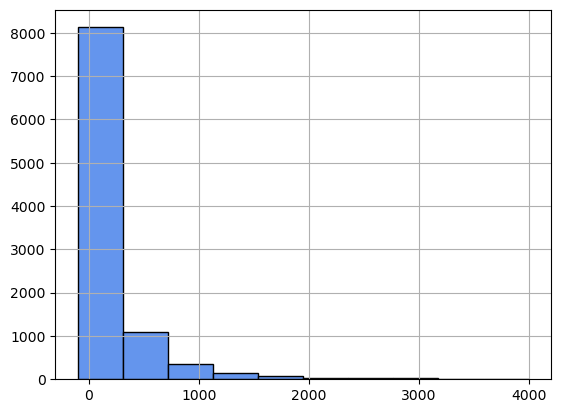

In [20]:
Orders2["Sales"].hist(color = "cornflowerblue", edgecolor = "k", range = [ -100 , 4000 ])

Перед нами визуализация распределения переменной Sales, то есть числа продаж. Исходя из того, что график скошен вправо, мы можем сказать, что наблюдаем гистограмму с положительным сдвигом (то есть продажи растут), что является хорошим фактором развития компании. Кстати, данную скошенность можно было предсказать на этапе агрегирования, так как среднее значение оказалось значительно выше медианного.

<AxesSubplot:>

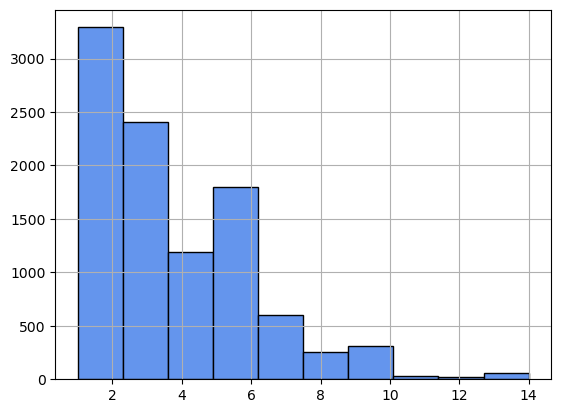

In [21]:
Orders2["Quantity"].hist(color = "cornflowerblue", edgecolor = "k")

Далее визуализация распределения переменной Quantity, то есть количества определенных проданных товаров. Исходя из того, что график скошен вправо, мы можем сказать, что наблюдаем гистограмму с положительным сдвигом (то есть определенные товары начинают покупать в большем количестве = рост спроса), что является хорошим фактором развития компании. Кстати, данную скошенность можно было предсказать на этапе агрегирования, так как среднее значение оказалось значительно выше медианного.

<AxesSubplot:>

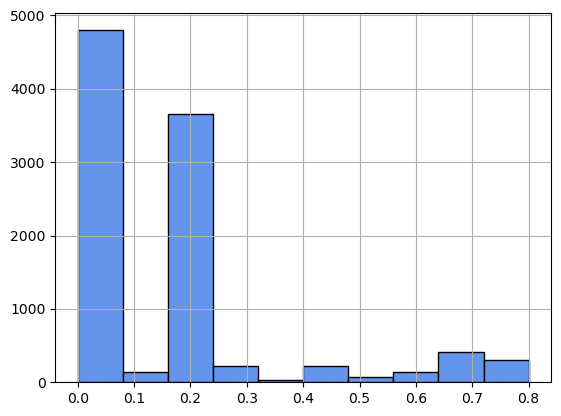

In [22]:
Orders2["Discount"].hist(color = "cornflowerblue", edgecolor = "k")

На этапе агрегирования было выяснено, что в данном случае среднее значение ниже медианного, однако совсем на немного (0.05). На гистограмме видно, что большинство значений находится слева, но и к правому краю значения тоже начинают возрастать, поэтому такую гистограмму правильно было бы назвать бимодальной, то есть принимающей несколько значений. На самом деле, это достаточно логичное распределение для переменной Discount, то есть для распределения скидок, так как скидки весьма непостоянны (например: сезонные скидки).

<AxesSubplot:>

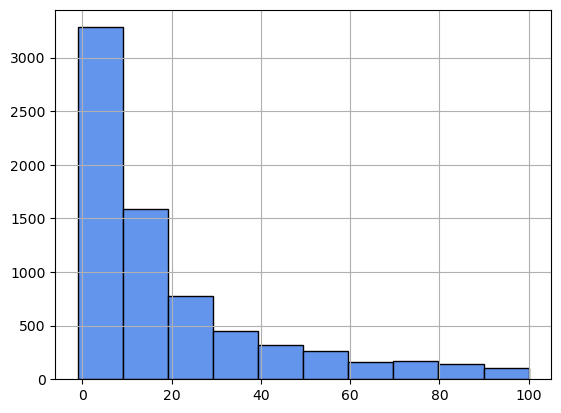

In [23]:
Orders2["Profit"].hist(color = "cornflowerblue", edgecolor = "k", range = [ -1 , 100 ]) 

Посмотрим на визуализацию распределения переменной Profit, то есть прибыли. Исходя из того, что график скошен вправо, мы можем сказать, что наблюдаем гистограмму с положительным сдвигом (то есть прибыль растет), что является хорошим фактором развития компании. Кстати, данную скошенность можно было предсказать на этапе агрегирования, так как среднее значение оказалось значительно выше медианного.

Теперь построим ящики с усами, чтобы зафиксировать нетипичные значения (если такие имеются) и в целом проанализировать изменение значений относительно временного ряда:

In [24]:
df = Orders1.copy()

<AxesSubplot:xlabel='month', ylabel='Sales'>

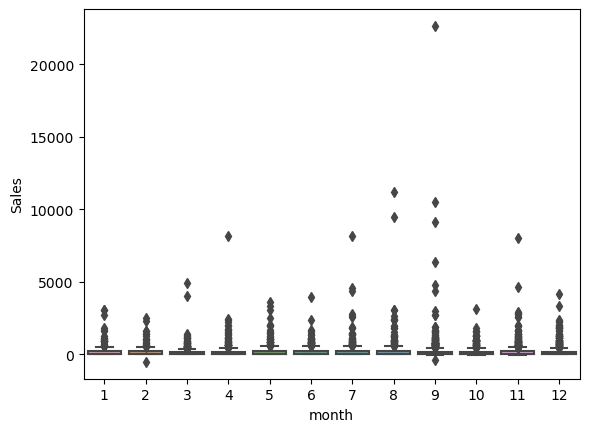

In [25]:
df['month'] = pd.DatetimeIndex(Orders1["Order Date"]).month
sns.boxplot(x = df['month'], y = Orders2["Sales"])

<AxesSubplot:xlabel='year', ylabel='Sales'>

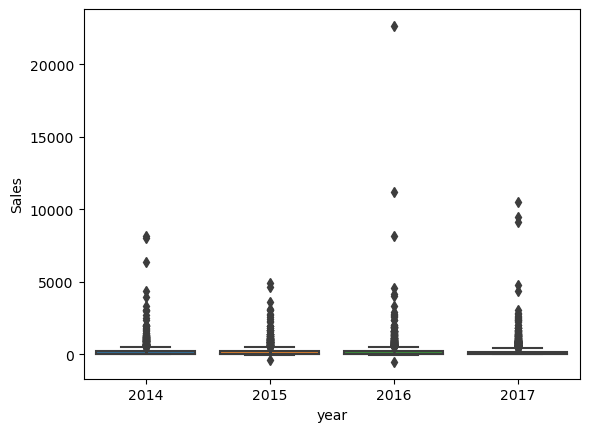

In [26]:
df['year'] = pd.DatetimeIndex(Orders1["Order Date"]).year
sns.boxplot(x = df['year'], y = Orders2["Sales"])

Первый график показывает, как изменялись значения Sales в течение 12 месяцев, а второй - в течение 4 лет. Точки над ящиками с усами представляют собой "выбросы", то есть нетипичные значения. 

Интерпритация:
* `Salesmonth`: высокие нетипичные значения наблюдаются в марте, апреле, июле, августе, сентябре и ноябре. Особенно выделяется месяц сентябрь, где самая высокая точка расположена в диапазоне > 20000. Отрицательные значения, то есть недостачи, присутствуют в феврале и сентябре. Среднее число продаж каждый месяц лежит в диапазоне от 0 до 4000.
* `Salesyear` : среднее число продаж каждый год не превышает 5000, однако мы можем наблюдать очень нетипичное значение в 2016 году.

<AxesSubplot:xlabel='month', ylabel='Quantity'>

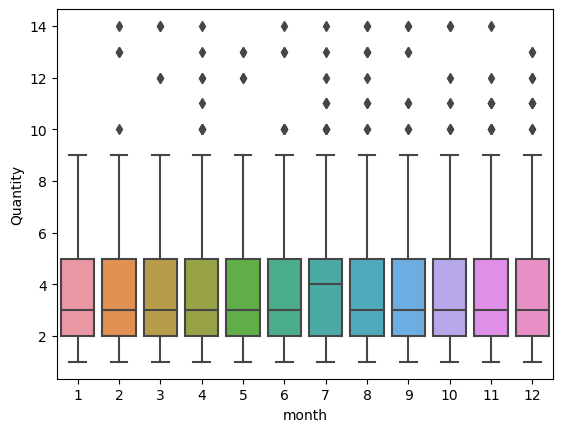

In [27]:
df['month'] = pd.DatetimeIndex(Orders1["Order Date"]).month
sns.boxplot(x = df['month'], y = Orders2["Quantity"])

<AxesSubplot:xlabel='year', ylabel='Quantity'>

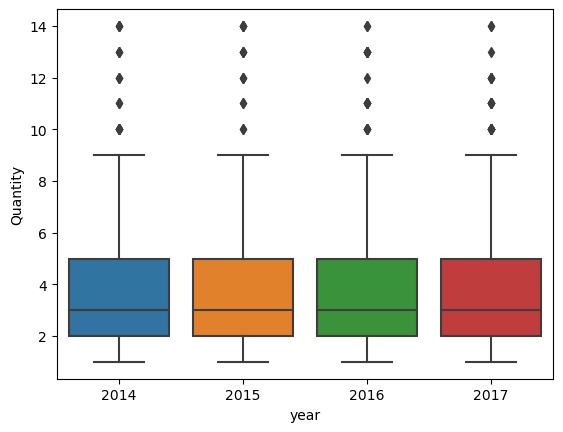

In [28]:
df['year'] = pd.DatetimeIndex(Orders1["Order Date"]).year
sns.boxplot(x = df['year'], y = Orders2["Quantity"])

Первый график показывает, как изменялись значения Quantity в течение 12 месяцев, а второй - в течение 4 лет. Точки над ящиками с усами представляют собой "выбросы", то есть нетипичные значения. 

Интерпритация:
* `Quantitymonth`: нетипично высокие значения наблюдаются каждый месяц, кроме января, также примечательно, что медианное значение в июле выше, чем в любой другой месяц.
* `Quantityyear` : мы видим достоточно стабильный график, за все 4 года - 4 идентичных ящика с усами. Нельзя сказать, что стабильность плохо влияет на компанию, поэтому в данном случае мы не будем рассматривать графики в негативном ключе.

<AxesSubplot:xlabel='month', ylabel='Discount'>

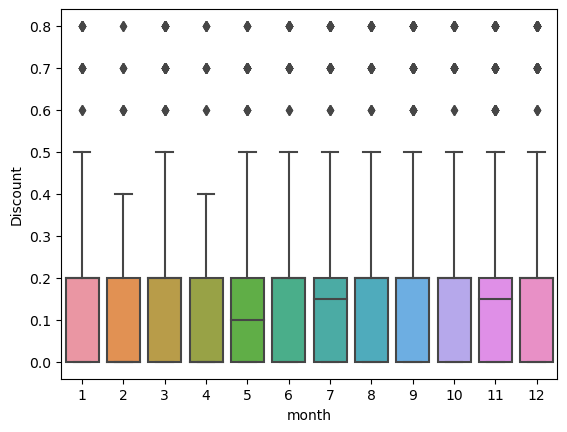

In [29]:
df['month'] = pd.DatetimeIndex(Orders1["Order Date"]).month
sns.boxplot(x = df['month'], y = Orders2["Discount"])

<AxesSubplot:xlabel='year', ylabel='Discount'>

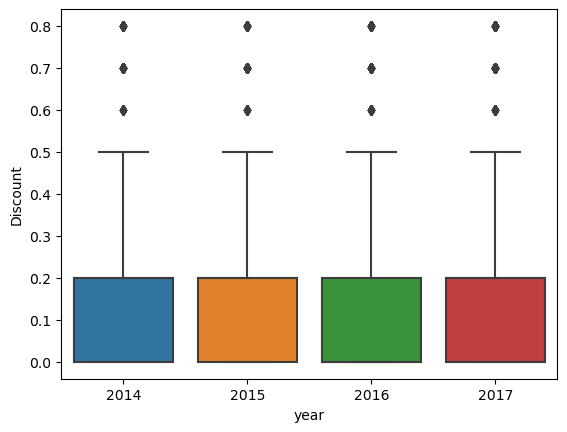

In [30]:
df['year'] = pd.DatetimeIndex(Orders1["Order Date"]).year
sns.boxplot(x = df['year'], y = Orders2["Discount"])

Первый график показывает, как изменялись значения Discount в течение 12 месяцев, а второй - в течение 4 лет. Точки над ящиками с усами представляют собой "выбросы", то есть нетипичные значения. 

Интерпритация:
* `Discountmonth`: нетипично высокие значения наблюдаются каждый месяц. Максимальные значения в феврале и марте ниже, чем в другие месяцы. Также примечательно, что медианное значение в июле и в ноябре выше, чем в любой другой месяц.
* `Discountyear` : мы видим достоточно стабильный график, за все 4 года - 4 идентичных ящика с усами. Нельзя сказать, что стабильность плохо влияет на компанию, поэтому в данном случае мы не будем рассматривать графики в негативном ключе.

<AxesSubplot:xlabel='month', ylabel='Profit'>

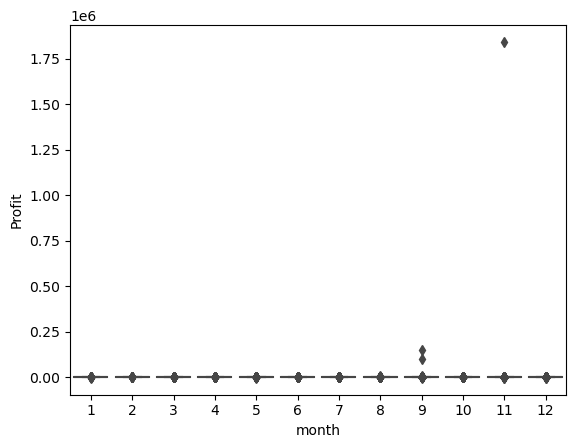

In [31]:
df['month'] = pd.DatetimeIndex(Orders1["Order Date"]).month
sns.boxplot(x = df['month'], y = Orders2["Profit"])

<AxesSubplot:xlabel='year', ylabel='Profit'>

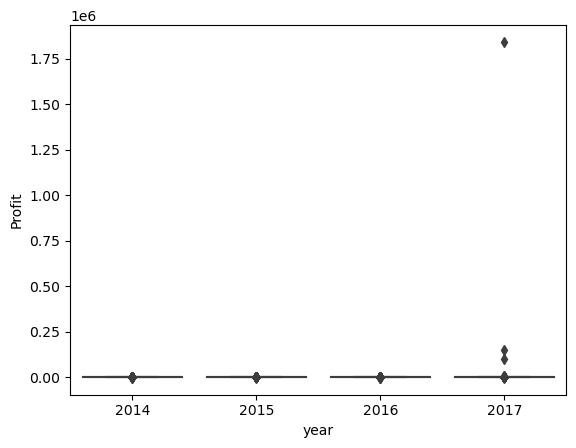

In [32]:
df['year'] = pd.DatetimeIndex(Orders1["Order Date"]).year
sns.boxplot(x = df['year'], y = Orders2["Profit"])

Первый график показывает, как изменялись значения Profit в течение 12 месяцев, а второй - в течение 4 лет. Точки над ящиками с усами представляют собой "выбросы", то есть нетипичные значения. 

Интерпритация:
* `Profitmonth`: нетипично высокие значения наблюдаются в сентябре и ноябре.
* `Profityear` : мы видим, что нетипичные значения присутсвуют в 2017 году, что является очередным подтвержением роста прибыли.

Пришло время обратиться к регрессии, чтобы проверить взаимосвязь данных:

Простая линейная регрессия моделирует взаимосвязь между двумя переменными. Пусть Profit (выручка) - это зависимая переменная, а Sales (продажи)и Discount (скидки) - независимые. Исходя из вышесказанного, построим две модели и проинтерпретируем их:

In [33]:
mod01 = ols("Profit ~ Sales", Orders2).fit()
print(mod01.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.094
Date:                Tue, 04 Nov 2025   Prob (F-statistic):              0.148
Time:                        03:31:05   Log-Likelihood:            -1.1202e+05
No. Observations:                9960   AIC:                         2.240e+05
Df Residuals:                    9958   BIC:                         2.241e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    139.6888    198.027      0.705      0.4

Интерпритация:
* `Intercept`: 139.6888 – это среднее ожидаемое значение зависимой переменной в случае, когда независимая переменная будет равна 0. Содержательно: если резко число продаж станет нулевым, компания некоторое время будет иметь пассивный доход.
* `Sales` : 0.4308 - это коэффициент при независимой переменной, который означает, что в среднем при увеличении независимой переменной Sales на 1, зависимая переменная Profit будет увеличиваться на 0.4308. Содержательно: прямая зависимость, то есть чем больше продаж, тем выше прибыль.

In [34]:
mod02 = ols("Profit ~ Discount", Orders2).fit()
print(mod02.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.112
Date:                Tue, 04 Nov 2025   Prob (F-statistic):              0.292
Time:                        03:31:07   Log-Likelihood:            -1.1236e+05
No. Observations:                9992   AIC:                         2.247e+05
Df Residuals:                    9990   BIC:                         2.247e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    385.7541    232.298      1.661      0.0

Интерпритация:
* `Intercept`: 385.7541 – это среднее ожидаемое значение зависимой переменной в случае, когда независимая переменная будет равна 0. Содержательно: если скидки станут нулевыми, компания будет иметь доход все равно, но не стремительно растущий.
* `Discount` : -945.9849 - это коэффициент при независимой переменной, который означает, что в среднем при увеличении независимой переменной Discount на 1, зависимая переменная Profit будет увеличиваться на -945.9849. Содержательно: чем больше скидок, тем меньше прибыль.

Множественная линейная регрессия моделирует несколько переменных и их влияние на результат. Пусть Profit (выручка) - это зависимая переменная, а Sales (продажи), Discount (скидки) и Quantity (количество проданных товаров) - независимые. Исходя из вышесказанного, построим модель и проинтерпретируем ее:

In [35]:
mod03 = ols("Profit ~ Quantity + Discount + Sales", Orders2).fit()
print(mod03.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.578
Date:                Tue, 04 Nov 2025   Prob (F-statistic):              0.192
Time:                        03:31:11   Log-Likelihood:            -1.1188e+05
No. Observations:                9947   AIC:                         2.238e+05
Df Residuals:                    9943   BIC:                         2.238e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -106.3933    393.159     -0.271      0.7

Интерпритация:
* `Intercept`: -106.3933 – это среднее ожидаемое значение зависимой переменной в случае, когда независимые переменные будут равны 0. Содержательно: если все переменные, которые влияют на прибыль, станут нулевыми, компания начнет терять средства.
* `Quantity` : 108.4906 - это коэффициент при независимой переменной, который означает, что в среднем при увеличении независимой переменной Quantity на 1, зависимая переменная Profit будет увеличиваться на 108.4906. Содержательно: каждая проданная единица товара в среднем приносит компании прибыль равную 108.4906.

Другие переменные проинтерпритированы под прошлыми моделями.

## Кластерный анализ

In [36]:
scale = ((Orders2 - Orders2.mean()) / Orders2.std())
scale = scale.dropna()
scale

,Sales,Quantity,Discount,Profit
0,0.051508,-0.804859,-0.756606,-0.010588
1,0.804503,-0.355514,-0.756606,-0.000993
2,-0.344777,-0.804859,-0.756606,-0.012481
3,1.166016,0.543176,1.423078,-0.033537
4,-0.332363,-0.804859,0.212143,-0.012716
...,...,...,...,...
9989,-0.327748,-0.355514,0.212143,-0.012630
9990,-0.220863,-0.804859,-0.756606,-0.012007
9991,0.046086,-0.804859,0.212143,-0.011804
9992,-0.320776,0.093831,-0.756606,-0.012132


In [37]:
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

In [38]:
kmeans = KMeans(init ='k-means++', n_clusters = 3 , n_init = 10 , random_state = 1 )
kmeans.fit(scale)
kmeans.labels_


array([1, 1, 1, ..., 1, 1, 1])

In [39]:
scale['Cluster'] = kmeans.labels_
scale

,Sales,Quantity,Discount,Profit,Cluster
0,0.051508,-0.804859,-0.756606,-0.010588,1
1,0.804503,-0.355514,-0.756606,-0.000993,1
2,-0.344777,-0.804859,-0.756606,-0.012481,1
3,1.166016,0.543176,1.423078,-0.033537,0
4,-0.332363,-0.804859,0.212143,-0.012716,1
...,...,...,...,...,...
9989,-0.327748,-0.355514,0.212143,-0.012630,1
9990,-0.220863,-0.804859,-0.756606,-0.012007,1
9991,0.046086,-0.804859,0.212143,-0.011804,1
9992,-0.320776,0.093831,-0.756606,-0.012132,1


In [40]:
clust_0 = scale[scale['Cluster'] == 0]
clust_1 = scale[scale['Cluster'] == 1]
clust_2 = scale[scale['Cluster'] == 2]
#сохранение в отдельные датафреймы

In [41]:
clust_0.describe()

,Sales,Quantity,Discount,Profit,Cluster
count,2239.000000,2239.000000,2239.000000,2239.000000,2239.0
mean,0.589657,1.465948,0.024386,-0.005176,0.0
std,1.909366,0.845280,1.012525,0.171546,0.0
min,-1.188263,-0.804859,-0.756606,-0.369274,0.0
25%,-0.295525,0.992521,-0.756606,-0.012578,0.0
50%,-0.060773,1.441866,0.212143,-0.011632,0.0
75%,0.739144,1.891210,0.212143,-0.008003,0.0
max,35.902842,4.587279,3.118388,8.017690,0.0


In [42]:
clust_1.describe()

,Sales,Quantity,Discount,Profit,Cluster
count,7707.000000,7707.000000,7707.000000,7707.000000,7707.0
mean,-0.171014,-0.425478,-0.005829,-0.011332,1.0
std,0.321474,0.525445,0.996726,0.061632,0.0
min,-1.040157,-1.254203,-0.756606,-0.155421,1.0
25%,-0.345733,-0.804859,-0.756606,-0.012767,1.0
50%,-0.304129,-0.355514,0.212143,-0.012485,1.0
75%,-0.137293,0.093831,0.212143,-0.011716,1.0
max,3.351914,0.543176,3.118388,5.387537,1.0


In [43]:
clust_2.describe()

,Sales,Quantity,Discount,Profit,Cluster
count,1.000000,1.000000,1.000000,1.000000,1.0
mean,0.685925,1.441866,-0.756606,99.472674,2.0
std,NaN,NaN,NaN,NaN,NaN
min,0.685925,1.441866,-0.756606,99.472674,2.0
25%,0.685925,1.441866,-0.756606,99.472674,2.0
50%,0.685925,1.441866,-0.756606,99.472674,2.0
75%,0.685925,1.441866,-0.756606,99.472674,2.0
max,0.685925,1.441866,-0.756606,99.472674,2.0


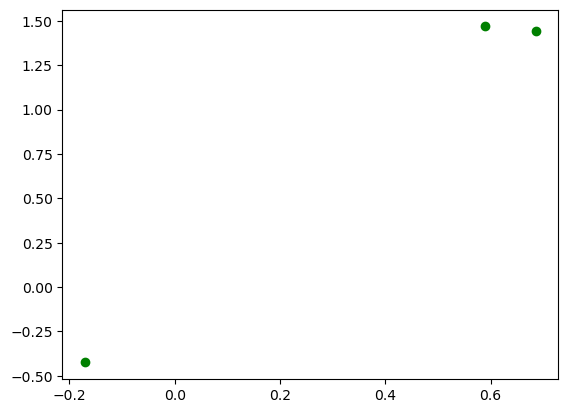

In [44]:
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1],  color='green')


In [45]:
scale["Cluster"].value_counts()

1    7707
0    2239
2       1
Name: Cluster, dtype: int64

In [46]:
med_scale = scale.groupby("Cluster").agg("median", numeric_only = True)
med_scale

,Sales,Quantity,Discount,Profit
Cluster,,,,
0,-0.060773,1.441866,0.212143,-0.011632
1,-0.304129,-0.355514,0.212143,-0.012485
2,0.685925,1.441866,-0.756606,99.472674


In [47]:
mean_scale = scale.groupby("Cluster").agg("mean", numeric_only = True)
mean_scale

,Sales,Quantity,Discount,Profit
Cluster,,,,
0,0.589657,1.465948,0.024386,-0.005176
1,-0.171014,-0.425478,-0.005829,-0.011332
2,0.685925,1.441866,-0.756606,99.472674


**Интерпритация:**

* `CLUSTER0`: – относительно второго кластера наблюдается весьма положительная динамика.

* `CLUSTER0`: – относительно других кластеров имеет отрицательную динамику.
* `CLUSTER3`: – в данный кластер отнесено лишь одно значение, которое имеет самые высокие описательные статистики.

Далее проиллюстрируем


C:\Users\admin\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\style.py:123: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


<AxesSubplot:title={'center':'Среднее число продаж по кластерам'}, xlabel='Cluster'>

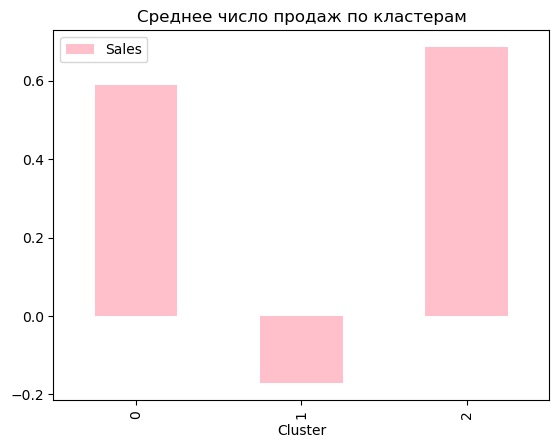

In [48]:
mean_scale.plot (y='Sales', kind='bar', colormap='coolwarm', title='Среднее число продаж по кластерам', color = 'pink')

<AxesSubplot:title={'center':'Среднее число количества проданных позиций по кластерам'}, xlabel='Cluster'>

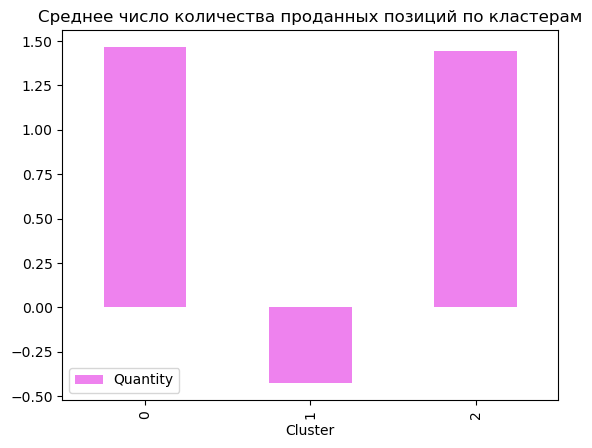

In [49]:
mean_scale.plot (y='Quantity', kind='bar', colormap='coolwarm', title='Среднее число количества проданных позиций по кластерам', color = 'violet')

<AxesSubplot:title={'center':'Скидки в среднем по кластерам'}, xlabel='Cluster'>

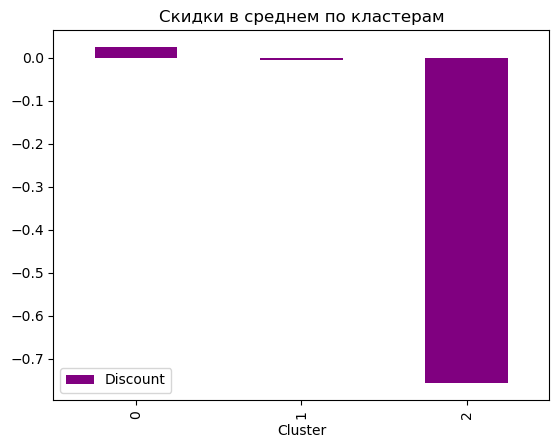

In [50]:
mean_scale.plot (y='Discount', kind='bar', colormap='coolwarm', title='Скидки в среднем по кластерам', color = 'purple')

<AxesSubplot:title={'center':'Среднее число прибыли по кластерам'}, xlabel='Cluster'>

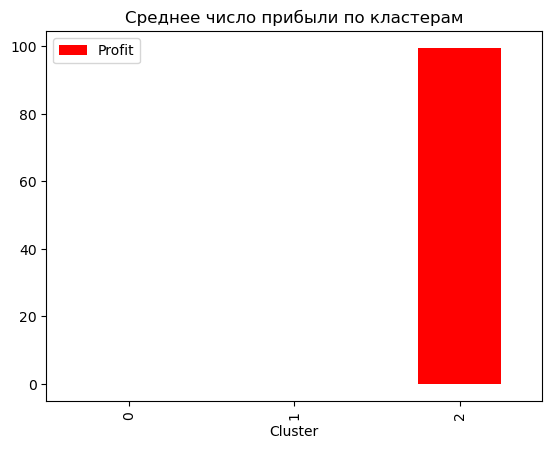

In [51]:
mean_scale.plot (y='Profit', kind='bar', colormap='coolwarm', title='Среднее число прибыли по кластерам', color = 'red' )

Еще более наглядной визуализации того, как распределены значения трех кластеров, можно добиться при помощи метода Варда:

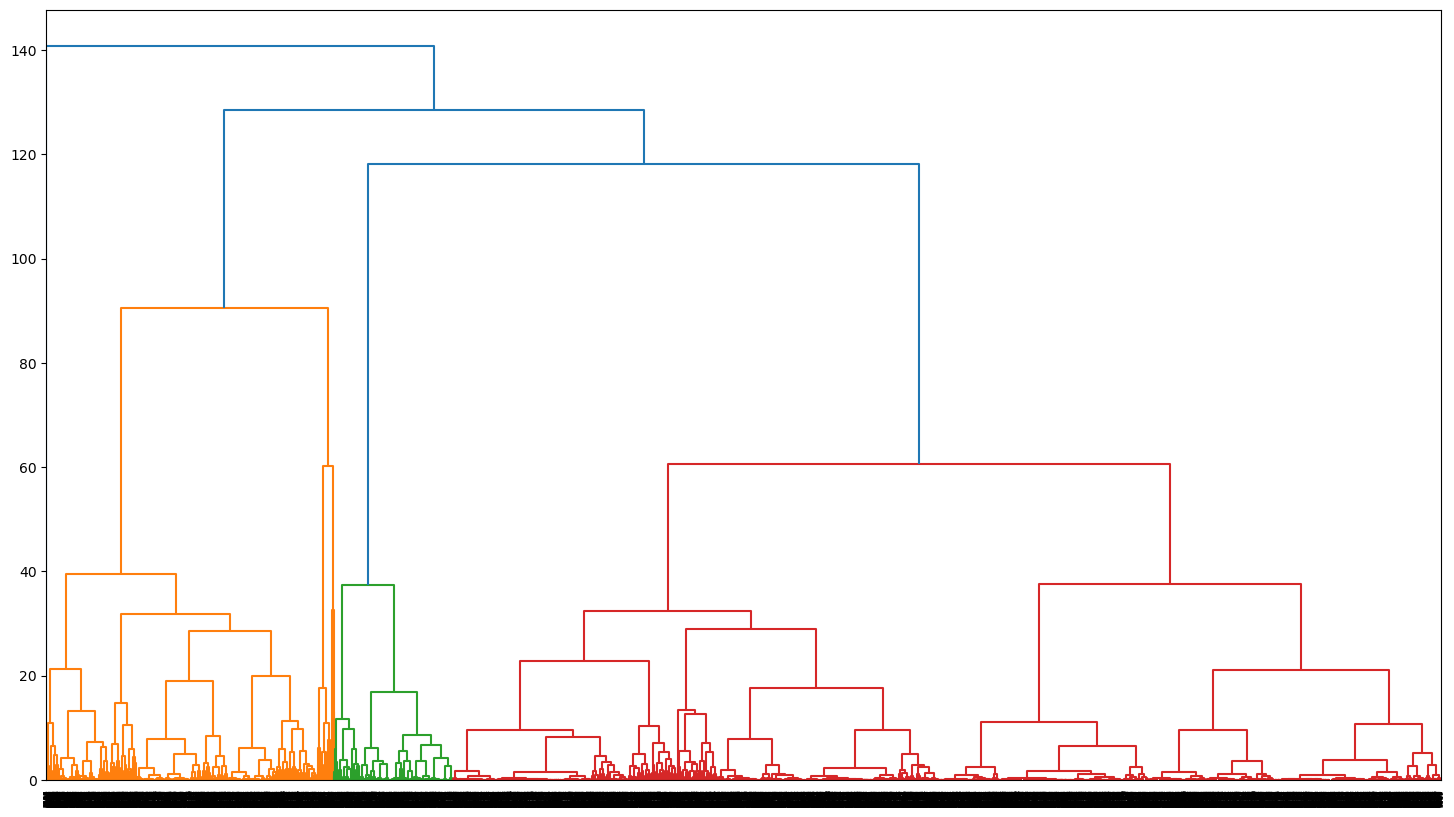

In [52]:
scale = linkage(scale, method = "ward")
plt.figure(figsize = (18, 10))
dendrogram(scale);

### Выводы на основании кластерного анализа

* `target`= выручка, которую мы попытаемся спрогнозировать на основании полученных данных! А именно, исходя из кластерного анализа. Глядя на графики, сосредоточимся на значениях кластера 1 и 2, кластер 3 состоит из одного значения, поэтому на него мы имеем право смотреть меньше. Итак, по визуализации понятно, что кластер 1 и 2 противоположны, но мы видим, что значений в кластере 1 намного больше, соответственно, еще одно доказательство того, что компания имеет хорошую прибыль, а отсюда и положительную выручку.

### Итоговый вывод

Еще на моменте построения диаграмм распределения и даже на моменте агрегации данных, мы заметили, что показатели компании, которые положительно вляют на доход, растут с каждым годом. Также положительный рост подтвердился при проведении кластерного анализа. Соответственно, мы можем спрогнозировать, что в ближайшие 2 года выручка компании имеет тенденцию к увеличению.